Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


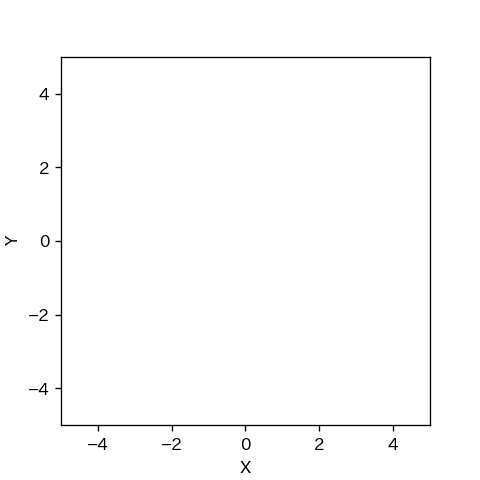

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


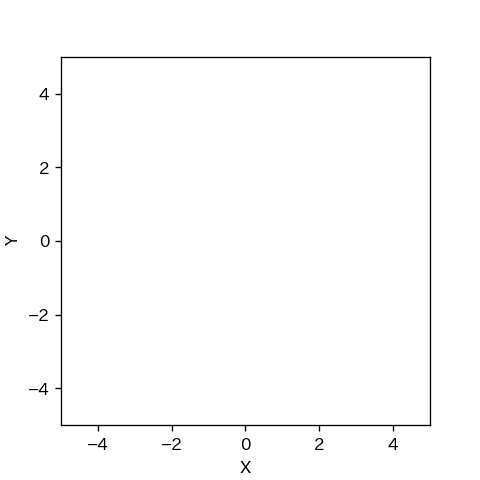

(array([ 4.12173382, -4.06481361,  1.41326465]),
 array([ 0.97107681,  4.08718004, -2.83722384]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [-6.25127966  2.501566    4.88568737] 推定値: [ 1.12899002 -0.15832653  5.75415877] 誤差: 7.844960719222129
[6.401071989592055]
1 真値: [2.36900377 4.74230262 3.24457481] 推定値: [3.10126218 5.40645478 2.57875478] 誤差: 0.9885850810063781
1
[5.0700576729355635]
2 真値: [-3.4722688 -3.3747384  6.3518444] 推定値: [-3.82515044 -3.57827455  6.43690252] 誤差: 0.40737257627966855
2
[6.5119588271768665]
3 真値: [-1.92446164 -4.34974052  6.21466008] 推定値: [-2.24851426 -5.23601094  6.36168789] 誤差: 0.9436553179038552
3
[5.065722478682903, 6.336804190949784]
4 真値: [-0.92136398 -3.29413331  6.03773089] 推定値: [-1.28445295 -3.10974418  5.92337033] 誤差: 0.40722592311622113
4
[5.801129601975826]
5 真値: [-3.35054128 -3.30780923  7.83863312] 推定値: [-3.71832416 -2.85035552  1.49091223] 誤差: 0.5869651899893341
5
[2.143203786277598]
6 真値: [-1.54678432  2.63304167  8.38437534] 推定値: [-2.30419696  2.53562063  2.09588684] 誤差: 0.7636522565328114
6
[3.1301315590387504, 4.1330632028160155]
7 真値: [ 4.90910758 -2.93258202  7.12458364] 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[4.603480451297979]
20 真値: [ 0.97194625 -0.89412721  6.89118271] 推定値: [ 1.56882093 -0.9745463   7.05020342] 誤差: 0.6022678914183325
17
[5.346486702102389]
[4.7764983501475635]
[2.8045857820427775, 4.370595416706217]
[4.1232653565558355]
21 真値: [1.39494005 0.54549849 8.01322788] 推定値: [1.42765422 0.75346853 1.65513213] 誤差: 0.2105273229213239
18
[3.755161793233878]
22 真値: [-1.24585958  2.62975122  5.10761676] 推定値: [-1.18243646  3.0372233   5.15036212] 誤差: 0.4123784530691632
19
[5.834203932823717]
23 真値: [-2.04924193 -4.54454993  3.00464127] 推定値: [4.32446767 0.49956037 0.14094473] 誤差: 8.128174623394269
[3.3820781594179774]
24 真値: [-0.05886603  4.97530247  3.31637742] 推定値: [-0.24744778  4.93442799  3.40158352] 誤差: 0.19296061786125693
20
[4.341366518771282]
[2.1533452121714713]
25 真値: [-2.92724872  1.24677863  6.00915091] 推定値: [-5.1484493   1.31281549  4.11032082] 誤差: 2.222182010829567
[1.8518235492267803]
26 真値: [-1.55655475 -0.06091673  6.9861071 ] 推定値: [-1.2523437  -0.15556844  0.80605401]